# Chapter 2. 자연어와 단어의 분산 표현

컴퓨터에게 단어의 의미를 이해시키기 위한 방법
- 시소러스(thesaurus, 유의어 사전) 활용
- 통계 기반 기법
- 추론 기반 기법 (word2vec)

In [60]:
import numpy as np
import matplotlib.pyplot as plt

## 2.2 시소러스

- 동의어/유의어가 한 그룹으로 분류
- 단어들을 의미의 상하위 / 전체와 부분 등의 관계에 기초해 그래프로 표현

### 2.2.1 WordNet
= 자연어처리 분야에서 가장 유명한 시소러스

In [ ]:
# Appendix B.

### 2.2.2 시소러스의 문제점
사람이 레이블링하는 방식이므로, 
- 신조어/의미 변화 등의 시대 변화에 대응하기 어렵다. 
- 큰 인적 비용 발생
- 단어의 미묘한 차이를 표현할 수 없다. (비슷한 단어를 단순히 묶으므로)

-> 통계 기반 기법, 추론 기반 기법 등장

## 2.3 통계 기반 기법
- 말뭉치(corpus) : (자연어 처리 연구나 어플리케이션을 염두해 두고 수집된) 대량의 텍스트 데이터

### 2.3.1 파이썬으로 말뭉치 전처리하기
- 텍스트 데이터를 단어로 분할하고 분할된 단어들을 단어 id 목록으로 변환하기

In [10]:
text = 'You say goodbye and I say hello.'

In [7]:
text = text.lower()
text = text.replace('.',' .'); text

'you say goodbye and i say hello .'

In [8]:
words = text.split(' '); words

['you', 'say', 'goodbye', 'and', 'i', 'say', 'hello', '.']

In [11]:
# 정규표현식 이용 <- ??
import re
re.split('(\W+)?',text)

['',
 None,
 'Y',
 None,
 'o',
 None,
 'u',
 ' ',
 '',
 None,
 's',
 None,
 'a',
 None,
 'y',
 ' ',
 '',
 None,
 'g',
 None,
 'o',
 None,
 'o',
 None,
 'd',
 None,
 'b',
 None,
 'y',
 None,
 'e',
 ' ',
 '',
 None,
 'a',
 None,
 'n',
 None,
 'd',
 ' ',
 '',
 None,
 'I',
 ' ',
 '',
 None,
 's',
 None,
 'a',
 None,
 'y',
 ' ',
 '',
 None,
 'h',
 None,
 'e',
 None,
 'l',
 None,
 'l',
 None,
 'o',
 '.',
 '',
 None,
 '']

- `r'\w+'`를 인자로 전달하면 whitespace 기준으로 문자열을 분리
- `\W `: 문자+숫자(alphanumeric)가 아닌 문자와 매치
- `+` : 앞에 있는 문자가 최소 한 번 이상 반복되어야 매치
- `?` : 앞에 있는 문자가 없거나 하나 있을 때 매치 (있어도 되고 없어도 된다)

In [12]:
word_to_id = {}
id_to_word = {}

for word in words :
  if word not in word_to_id :
    new_id = len(word_to_id)    #id는 {0 ,1, 2 ... 이런 식으로 증가}
    word_to_id[word] = new_id
    id_to_word[new_id] = word

In [13]:
id_to_word

{0: 'you', 1: 'say', 2: 'goodbye', 3: 'and', 4: 'i', 5: 'hello', 6: '.'}

In [14]:
word_to_id

{'.': 6, 'and': 3, 'goodbye': 2, 'hello': 5, 'i': 4, 'say': 1, 'you': 0}

In [17]:
corpus = [word_to_id[w] for w in words]
corpus = np.array(corpus);corpus

array([0, 1, 2, 3, 4, 1, 5, 6])

> 코드로 정리

In [18]:
def preprocess(text) :
  text= text.lower()
  text = text.replace('.',' .')
  words = text.split(' ')
  
  word_to_id = {}
  id_to_word = {}
  for word in words :
    if word not in word_to_id :
      new_id = len(word_to_id)
      word_to_id[word] = new_id
      id_to_word[new_id] = word
  
  corpus = np.array([word_to_id[w] for w in words])
  
  return corpus, word_to_id, id_to_word

In [19]:
text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)

### 2.3.2 단어의 분산 표현
- 단어의 의미를 파악할 수 있는 벡터 표현
- 단어의 분산 표현은 단어를 고정 길의 의 밀집벡터(dense vector)로 표현

### 2.3.3 분포 가설
: 단어의 의미는 주변 단어(단어가 사용된 맥락-context-)에 의해 형성된다.

- `맥락` : 특정 단어를 중심에 둔 그 주변의 단어
- 맥락의 크기 = 윈도우 크기 : 주변 단어를 몇개나 포함할지</br>
e.g. 윈도우 크기가 2면 단어를 중심으로 좌우 2단어씩 포함


### 2.3.4 동시발생 행렬
= 모든 단어에 대해 동시발생하는 단어를 표에 정리한 행렬

- 주변에 어떤 단어가 몇번이나 등장하는지 세어 집계하는 방법 = 통계 기반 기법

In [20]:
corpus

array([0, 1, 2, 3, 4, 1, 5, 6])

In [21]:
id_to_word

{0: 'you', 1: 'say', 2: 'goodbye', 3: 'and', 4: 'i', 5: 'hello', 6: '.'}

In [22]:
def create_co_matrix(corpus, vocab_size, window_size=1) :
  corpus_size = len(corpus)
  co_matrix = np.zeros((vocab_size,vocab_size), dtype= np.int32)

  for idx, word_id in enumerate(corpus) :
    for i in range(1, window_size+1) :
      left_idx = idx - i
      right_idx = idx + i
      if left_idx >= 0 :
        left_word_id = corpus[left_idx]
        co_matrix[word_id,left_word_id] += 1
      if right_idx < corpus_size :
        right_word_id = corpus[right_idx]
        co_matrix[word_id, right_word_id] += 1
  
  return co_matrix

### 2.3.5 벡터 간 유사도

- 코사인 유사도
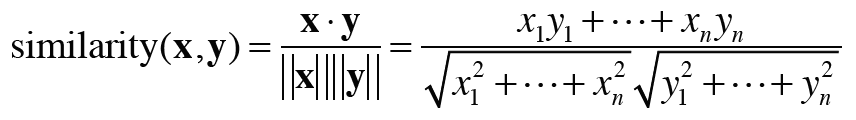

  - 분자 : 벡터의 내적
  - 분모 : 벡터의 norm
  - 벡터를 정규화 한 후 내적
  - 벡터의 방향이 완전히 같다면 1, 반대라면 -1

In [31]:
def cos_similarity(x,y, eps =1e-8) : 
  nx = x / np.sqrt(np.sum(x**2)+eps)
  ny = y / np.sqrt(np.sum(y**2)+eps)
  return np.dot(nx,ny)

분모에 매우 작은값(eps)를 더해줘 `devide by zero` 오류 방지

In [23]:
text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)
vocab_size = len(word_to_id)
C = create_co_matrix(corpus,vocab_size)

In [25]:
c0 = C[word_to_id['you']]   #'you'의 단어벡터
c1 = C[word_to_id['i']]     #'i'의 단어벡터
print(cos_similarity(c0,c1))

0.7071067758832467


코사인 유사도 값의 범위는 -1~1 사이이므로 비교적 유사성이 높다고 볼 수 있음

### 2.3.6 유사 단어의 랭킹 표시

- 어떤 단어가 검색어로 주어지면, 그 검색어와 비슷한 단어를 유사도 순으로 출력하는 함수 구현

In [36]:
def most_similar(query, word_to_id, id_to_word, word_matrix, top=5) :
  # 1. 검색어를 꺼낸다
  if query not in word_to_id :
    print("%s를 찾을 수 없습니다."%query)
    return 
  
  print('\n[query]' + query)
  query_id = word_to_id[query]
  query_vec = word_matrix[query_id]

  # 2. 코사인 유사도 계산
  vocab_size = len(id_to_word)
  similarity = np.zeros(vocab_size)
  for i in range(vocab_size) :
    similarity[i] = cos_similarity(query_vec,word_matrix[i])

  # 3. 코사인 유사도를 기준으로 내림차순으로 출력
  count = 0
  for i in (-1*similarity).argsort() :
    if id_to_word[i] == query :
      continue
    print('%s : %s'%(id_to_word[i], similarity[i]))
    count += 1
    if count >= top :
      return


- `numpy.argsort()` : array를 오름차순으로 정렬 후 인덱스를 반환
</br> -> 여기에 `-`를 붙였으니까 위 함수는 내림차순 정렬

In [37]:
most_similar('you', word_to_id, id_to_word, C)


[query]you
goodbye : 0.7071067758832467
i : 0.7071067758832467
hello : 0.7071067758832467
say : 0.0
and : 0.0


## 2.4 통계 기반 기법 개선하기

### 2.4.1 상호정보량

- 점별 상호정보량(PMI, Pointwize Mutual Information)

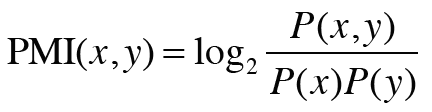

    - P(x,y) : x와 y가 동시에 등장할 확률
    - PMI값이 높을수록 관련성이 높다는 의미

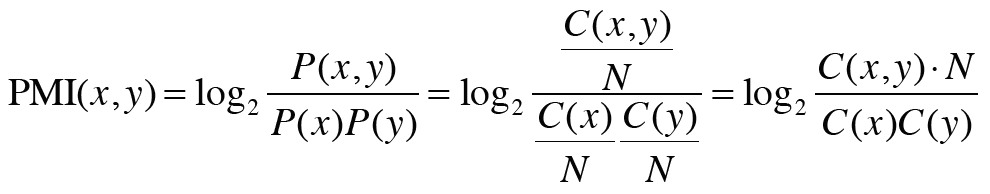

    - C는 동시발생행렬

단, 두 단어의 동시 발생 횟수가 0이면 $log_20 = -\infty$ 이기 때문에 **양의 상호정보량(PPMI)**을 사용

$PPMI(x,y) = max(0,PMI(x,y))$
- PMI가 음수일 때는 0으로 취급

In [51]:
def ppmi(C, verbose=False, eps=1e-8) :    # C : 동시발생행렬
  M = np.zeros_like(C, dtype=np.float32)  
  N = np.sum(C)                           # N : sum(axis=None) -> 모든 원소 값을 다 더해서 반환, 동시 발생된 모든 단어의 개수
  S = np.sum(C, axis=0)                   # S : 각 단어별 동시 발생 횟수
  total = C.shape[0]*C.shape[1]           # total : 전체 행렬 크기
  #print(N,S,total)
  cnt = 0

  for i in range(C.shape[0]) :
    for j in range(C.shape[1]) :
      pmi = np.log2(C[i,j]*N / (S[j]+S[i])+eps)
      M[i,j] = max(0,pmi)

      if verbose :
        cnt+=1
        if cnt % (total//100) == 0 :
          print('%.1f%% 완료'%(100*cnt/total))

  return M

In [52]:
text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)
vocab_size = len(word_to_id)
C = create_co_matrix(corpus, vocab_size)
W = ppmi(C)

np.set_printoptions(precision=3)  # 유효 자릿수를 세 자리로 표시
print('동시발생 행렬')
print(C)
print('-'*50)
print('PPMI')
print(W)

동시발생 행렬
[[0 1 0 0 0 0 0]
 [1 0 1 0 1 1 0]
 [0 1 0 1 0 0 0]
 [0 0 1 0 1 0 0]
 [0 1 0 1 0 0 0]
 [0 1 0 0 0 0 1]
 [0 0 0 0 0 1 0]]
--------------------------------------------------
PPMI
[[0.    1.485 0.    0.    0.    0.    0.   ]
 [1.485 0.    1.222 0.    1.222 1.222 0.   ]
 [0.    1.222 0.    1.807 0.    0.    0.   ]
 [0.    0.    1.807 0.    1.807 0.    0.   ]
 [0.    1.222 0.    1.807 0.    0.    0.   ]
 [0.    1.222 0.    0.    0.    0.    2.222]
 [0.    0.    0.    0.    0.    2.222 0.   ]]


But, 말뭉치의 어휘 수가 증가하면 벡터 차원 수도 동일하게 증가.</br>
&& 게다가 현재는 대부분의 원소가 0으로 이루어져 있음 -> 각 원소의 중요도가 낮음

### 2.4.2 차원 감소
: 중요한 정보는 최대한 유지하면서 벡터의 차원을 줄이는 방법
- 희소 벡터에서 중요한 축을 찾아내어 더 적은 차원으로 다시 표현
- 차원 감소의 결과로 희소벡터 ->  밀집벡터로 변환


- 대표적인 방법 :  특잇값분해(SVD, Singular Value Decomposition) <br>
$X = USV^T$ <br>
임의의 행렬 X를 U,S,V라는 세 행렬의 곱으로 분해
  - U와 V는 직교행렬(orthogonal matrix)
  - S는 대각행렬(diagonal matrix)
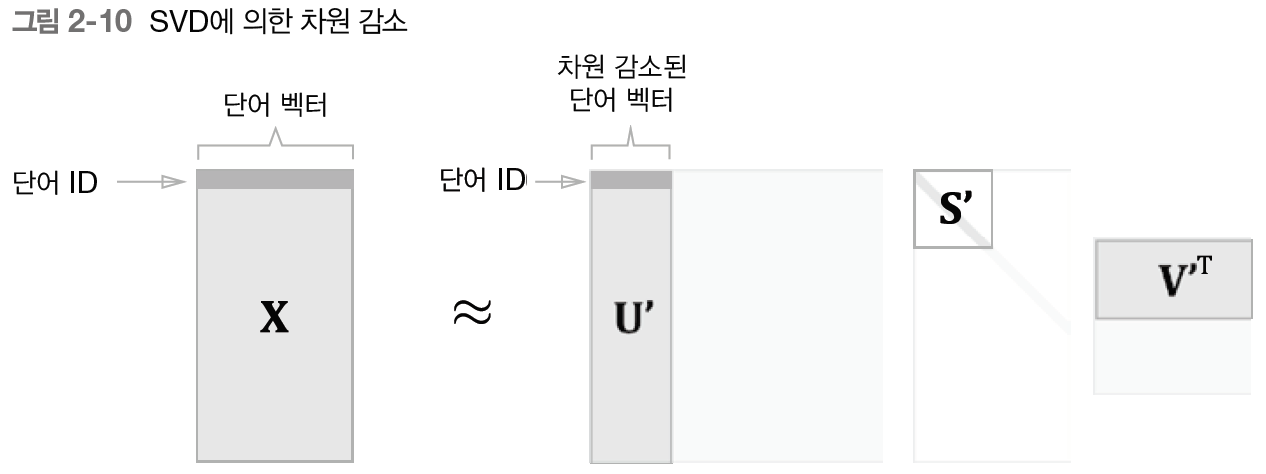

    - U : 단어공간
    - S : 특이값(해당 축의 중요도)이 큰 순서대로 대각성분이 나열 
    - 행렬 X : 해당 단어 ID의 단어 벡터가 저장
    - 행렬 U'라는 차원 감소된 벡터로 표현

### 2.4.3 SVD에 의한 차원 감소
- numpy의 `linalg` 모듈 활용

In [54]:
text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)
vocab_size = len(id_to_word)
C = create_co_matrix(corpus, vocab_size, window_size=1)
W = ppmi(C)

# SVD
U, S, V = np.linalg.svd(W)  #W를 U,S,V로 SVD분해

In [55]:
C[0]  #동시발생 행렬

array([0, 1, 0, 0, 0, 0, 0], dtype=int32)

In [56]:
W[0]  #PPMI 행렬

array([0.   , 1.485, 0.   , 0.   , 0.   , 0.   , 0.   ], dtype=float32)

In [57]:
U[0]  #SVD

array([ 0.000e+00,  3.146e-01, -8.327e-17, -8.970e-02,  9.450e-01,
        0.000e+00, -5.001e-17], dtype=float32)

희소벡터였던 `W[0]`가 밀집벡터 `U[0]`로 변화

In [58]:
#2차원 벡터로 줄이려면... 처음 2개 벡터까지만 꺼내면 됨
U[0,:2]

array([0.   , 0.315], dtype=float32)

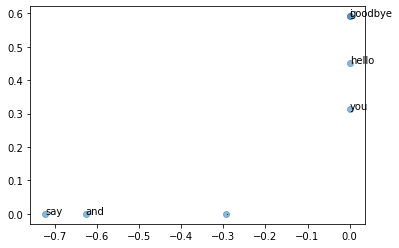

In [61]:
# 플롯
for word, word_id in word_to_id.items():
    plt.annotate(word, (U[word_id, 0], U[word_id, 1]))
plt.scatter(U[:,0], U[:,1], alpha=0.5)
plt.show()

- goodbye와 hello가 가까이 있음.


SVD계산은 $O(N^3)$ 의 시간복잡도를 가짐. -> 더 빠른 기법인 `Truncated SVD` (특이값이 작은 것을 버림)를 이용

### 2.4.4 PTB 데이터셋
: 펜 트리뱅크(PTB, Penn Treebank) 말뭉치

- 주어진 기법의 품질을 측정하는 벤치마크로 자주 이용 

In [65]:
import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks/DLfromScratch/2/deep-learning-from-scratch-2-master/')
from dataset import ptb

corpus, word_to_id, id_to_word = ptb.load_data('train')

print('말뭉치 크기:', len(corpus))
print('corpus[:30]:', corpus[:30])
print()
print('id_to_word[0]:', id_to_word[0])
print('id_to_word[1]:', id_to_word[1])
print('id_to_word[2]:', id_to_word[2])
print()
print("word_to_id['car']:", word_to_id['car'])
print("word_to_id['happy']:", word_to_id['happy'])
print("word_to_id['lexus']:", word_to_id['lexus'])

corpus, word_to_id, id_to_word = ptb.load_data('train')

print('말뭉치 크기:', len(corpus))
print('corpus[:30]:', corpus[:30])
print()
print('id_to_word[0]:', id_to_word[0])
print('id_to_word[1]:', id_to_word[1])
print('id_to_word[2]:', id_to_word[2])
print()
print("word_to_id['car']:", word_to_id['car'])
print("word_to_id['happy']:", word_to_id['happy'])
print("word_to_id['lexus']:", word_to_id['lexus'])

Done
말뭉치 크기: 929589
corpus[:30]: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]

id_to_word[0]: aer
id_to_word[1]: banknote
id_to_word[2]: berlitz

word_to_id['car']: 3856
word_to_id['happy']: 4428
word_to_id['lexus']: 7426
말뭉치 크기: 929589
corpus[:30]: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]

id_to_word[0]: aer
id_to_word[1]: banknote
id_to_word[2]: berlitz

word_to_id['car']: 3856
word_to_id['happy']: 4428
word_to_id['lexus']: 7426


### 2.4.5 PTB 데이터셋 평가

사이킷런의 고속 SVD (Truncated SVD) 사용

In [66]:
window_size = 2
wordvec_size = 100

corpus, word_to_id, id_to_word = ptb.load_data('train')
vocab_size = len(word_to_id)
print('동시발생 수 계산 ...')
C = create_co_matrix(corpus, vocab_size, window_size)
print('PPMI 계산 ...')
W = ppmi(C, verbose=True)

print('calculating SVD ...')
try:
    # truncated SVD (빠르다!)
    from sklearn.utils.extmath import randomized_svd
    U, S, V = randomized_svd(W, n_components=wordvec_size, n_iter=5,random_state=None)
except ImportError:
    # SVD (느리다)
    U, S, V = np.linalg.svd(W)

word_vecs = U[:, :wordvec_size]

querys = ['you', 'year', 'car', 'toyota']
for query in querys:
    most_similar(query, word_to_id, id_to_word, word_vecs, top=5)

동시발생 수 계산 ...
PPMI 계산 ...
1.0% 완료
2.0% 완료
3.0% 완료
4.0% 완료
5.0% 완료
6.0% 완료
7.0% 완료
8.0% 완료
9.0% 완료
10.0% 완료
11.0% 완료
12.0% 완료
13.0% 완료
14.0% 완료
15.0% 완료
16.0% 완료
17.0% 완료
18.0% 완료
19.0% 완료
20.0% 완료
21.0% 완료
22.0% 완료
23.0% 완료
24.0% 완료
25.0% 완료
26.0% 완료
27.0% 완료
28.0% 완료
29.0% 완료
30.0% 완료
31.0% 완료
32.0% 완료
33.0% 완료
34.0% 완료
35.0% 완료
36.0% 완료
37.0% 완료
38.0% 완료
39.0% 완료
40.0% 완료
41.0% 완료
42.0% 완료
43.0% 완료
44.0% 완료
45.0% 완료
46.0% 완료
47.0% 완료
48.0% 완료
49.0% 완료
50.0% 완료
51.0% 완료
52.0% 완료
53.0% 완료
54.0% 완료
55.0% 완료
56.0% 완료
57.0% 완료
58.0% 완료
59.0% 완료
60.0% 완료
61.0% 완료
62.0% 완료
63.0% 완료
64.0% 완료
65.0% 완료
66.0% 완료
67.0% 완료
68.0% 완료
69.0% 완료
70.0% 완료
71.0% 완료
72.0% 완료
73.0% 완료
74.0% 완료
75.0% 완료
76.0% 완료
77.0% 완료
78.0% 완료
79.0% 완료
80.0% 완료
81.0% 완료
82.0% 완료
83.0% 완료
84.0% 완료
85.0% 완료
86.0% 완료
87.0% 완료
88.0% 완료
89.0% 완료
90.0% 완료
91.0% 완료
92.0% 완료
93.0% 완료
94.0% 완료
95.0% 완료
96.0% 완료
97.0% 완료
98.0% 완료
99.0% 완료
100.0% 완료
calculating SVD ...

[query]you
i : 0.524336040019989
we : 0.5157831907272339
me :

## 2.5 정리

1. WordNet 등의 시소러스를 이용하면 유의어를 얻거나 단어 사이의 유사도를 측정하는 등 유용한 작업을 할 수 있다. 
2. 하지만 수동으로 구축해야하는 시소러스 기반 기법은 한계가 있다. 
3. 그래서 현재는 말뭉치를 이용해 단어를 벡터화하는 방식이 주로 쓰인다. 
4. 최근의 단어 벡터화 기법들은 대부분 `단어의 의미는 주변 단어에 의해 형성된다.` 는 분포 가설에 기초한다. 
5. 통계 기반 기법은 말뭉치 안의 각 단어에 대해서 그 단어 주변 단어의 빈도를 집계한다. (=동시발생 행렬)
6. 동시발생 행렬을 PPMI 행렬로 변환하고 -> 차원을 감소시킴으로써, 거대한 희소벡터를 밀집벡터로 변환할 수 있다. 
7. 단어의 벡터 공간에서는 의미가 가까운 단어는 그 거리도 가까울 것으로 기대된다. 